In [1]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import *
import tensorflow as tf
import numpy as np
import baseline_model as model

c:\Users\phong\.conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Data preparation

In [2]:
no_of_sensor = 32
# Prepare field data
Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_train:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    print(sensor_data.shape)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_array = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_array = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_array.shape)
print(full_field_data_whole_array.shape)

# Normalization
min_val = np.amin(full_field_data_whole_array)
max_val = np.amax(full_field_data_whole_array)
full_field_data_whole_array_norm = (full_field_data_whole_array - min_val)/(max_val - min_val)
sensor_data_whole_array_norm = (sensor_data_whole_array - min_val)/(max_val - min_val)

dim = full_field_data_whole_array_norm.shape
x = tf.linspace(0, dim[2], dim[2])
y = tf.linspace(0, dim[1], dim[1])
coordX, coordY = np.meshgrid(x, y)
coordX = np.expand_dims(coordX, axis = -1)
coordY = np.expand_dims (coordY, axis = -1)
input_coord = np.concatenate([coordX,coordY], axis = -1)
input_coord = np.repeat(input_coord[np.newaxis,:,:,:], dim[0], axis = 0)

# # Test
# print("Check field data: ", np.amin(full_field_data_whole_array_norm), np.amax(full_field_data_whole_array_norm))
# print("Check sens data: ", np.amin(sensor_data_whole_array_norm), np.amax(sensor_data_whole_array_norm))




(32, 39)
(32, 39)
(32, 39)
(32, 39)
(32, 39)
(32, 39)
(32, 39)
(32, 39)
(32, 39)
(32, 39)
(32, 39)
(429, 32)
(429, 128, 256, 1)


In [3]:
sensor_data_whole_array_norm.shape

sensor_data_inr = np.ones(shape = (input_coord.shape[0],input_coord.shape[1],input_coord.shape[2],sensor_data_whole_array_norm.shape[-1]))
sensor_data_inr.shape
for i in range(input_coord.shape[0]):
    for j in range(sensor_data_whole_array_norm.shape[-1]):
        sensor_data_inr[i,:,:,j] = sensor_data_inr[i,:,:,j]*sensor_data_whole_array_norm[i,j]
sensor_data_inr.shape

(429, 128, 256, 32)

In [4]:
input_coord.shape[0]*input_coord.shape[1]*input_coord.shape[2]

14057472

In [32]:
sensor_data_inr.shape

(429, 128, 256, 8)

In [4]:
input_coord = input_coord.reshape((input_coord.shape[0]*input_coord.shape[1]*input_coord.shape[2],2))
full_field_data_whole_array_norm = full_field_data_whole_array_norm.reshape((full_field_data_whole_array.shape[0]*full_field_data_whole_array.shape[1]*full_field_data_whole_array.shape[2],full_field_data_whole_array.shape[3]))
sensor_data_inr = sensor_data_inr.reshape((sensor_data_inr.shape[0]*sensor_data_inr.shape[1]*sensor_data_inr.shape[2],sensor_data_inr.shape[-1]))

In [5]:
# Create tf.dataset
dataset = tf.data.Dataset.from_tensor_slices(((sensor_data_inr,input_coord),full_field_data_whole_array_norm))
dataset = dataset.shuffle(buffer_size = 14057472) 
dataset = dataset.batch(2048)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(None, 32), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [9]:
input_coord.shape


(1277952, 2)

In [10]:
full_field_data_whole_array_norm.shape

(1277952, 1)

In [11]:
sensor_data_inr.shape

(1277952, 8)

In [3]:
def INR(no_of_sensor = 8):
    inputs = keras.Input(shape = (no_of_sensor))
    inputs_coords = keras.Input(shape = (2))
    concat = Concatenate()([inputs,inputs_coords])
    fc_1 = Dense(128, activation='relu')(concat)
    bn_1 = BatchNormalization()(fc_1)
    fc_2 = Dense(256, activation='relu')(bn_1)
    bn_2 = BatchNormalization()(fc_2)

    fc_3 = Dense(128, activation='relu')(bn_2)
    bn_3 = BatchNormalization()(fc_3)

    fc_5 = Dense(1)(bn_3)
    
    inr_model = keras.Model([inputs,inputs_coords], fc_5)
    return inr_model

## Training

In [23]:
# tf.keras.backend.clear_session()
# mlp_recon = INR(no_of_sensor = no_of_sensor)
# mlp_recon.summary()
# mlp_recon.compile(loss= 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999))
mlp_recon.fit(dataset, epochs =  25, shuffle = True)

Epoch 1/25
6864/6864 [==============================] - 391s 43ms/step - loss: 4.7980e-04
Epoch 2/25
6864/6864 [==============================] - 407s 44ms/step - loss: 4.7490e-04
Epoch 3/25
6864/6864 [==============================] - 405s 43ms/step - loss: 4.7309e-04
Epoch 4/25
6864/6864 [==============================] - 413s 44ms/step - loss: 4.6666e-04
Epoch 5/25
6864/6864 [==============================] - 410s 44ms/step - loss: 4.6310e-04
Epoch 6/25
6864/6864 [==============================] - 416s 44ms/step - loss: 4.5853e-04
Epoch 7/25
6864/6864 [==============================] - 420s 45ms/step - loss: 4.5486e-04
Epoch 8/25
6864/6864 [==============================] - 414s 44ms/step - loss: 4.5030e-04
Epoch 9/25
6864/6864 [==============================] - 415s 44ms/step - loss: 4.4728e-04
Epoch 10/25
6864/6864 [==============================] - 421s 45ms/step - loss: 4.4319e-04
Epoch 11/25
6864/6864 [==============================] - 415s 44ms/step - loss: 4.4384e-04
Epoch 12

In [4]:
filename = 'inr_' + str(no_of_sensor) + '_ran.h5'
# mlp_recon.save_weights(filename)


In [25]:
mlp_recon.save_weights(filename)


In [5]:
mlp_recon = INR(no_of_sensor = no_of_sensor)
mlp_recon.summary()
mlp_recon.load_weights(filename)

mlp_recon.compile(loss= 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 34)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          4480        ['concatenate[0][0]']        

In [6]:
# Save model weight
# Prepare field data

# Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [750]
# , 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_test:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_test = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_test = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_test.shape)
print(full_field_data_whole_test.shape)

full_field_data_whole_test_norm = (full_field_data_whole_test - min_val)/(max_val - min_val)
sensor_data_whole_test_norm = (sensor_data_whole_test - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_test_norm), np.amax(full_field_data_whole_test_norm))
print("Check sens data: ", np.amin(sensor_data_whole_test_norm), np.amax(sensor_data_whole_test_norm))

dim = full_field_data_whole_test_norm.shape
print(dim)
x = tf.linspace(0, dim[2], dim[2])
y = tf.linspace(0, dim[1], dim[1])
coordX, coordY = np.meshgrid(x, y)
coordX = np.expand_dims(coordX, axis = -1)
coordY = np.expand_dims (coordY, axis = -1)
input_coord_test = np.concatenate([coordX,coordY], axis = -1)
input_coord_test = np.repeat(input_coord_test[np.newaxis,:,:,:], dim[0], axis = 0)

(39, 32)
(39, 128, 256, 1)
Check field data:  0.0 0.9602790738963307
Check sens data:  0.03375052530369872 0.8428007556895063
(39, 128, 256, 1)


In [7]:
sensor_data_whole_test_norm.shape

sensor_data_inr_test = np.ones(shape = (input_coord_test.shape[0],input_coord_test.shape[1],input_coord_test.shape[2],sensor_data_whole_test_norm.shape[-1]))
sensor_data_inr_test.shape
for i in range(input_coord_test.shape[0]):
    for j in range(sensor_data_whole_test_norm.shape[-1]):
        sensor_data_inr_test[i,:,:,j] = sensor_data_inr_test[i,:,:,j]*sensor_data_whole_test_norm[i,j]
sensor_data_inr_test.shape

(39, 128, 256, 32)

In [9]:
input_coord_test.shape
sensor_data_inr_test.shape

(39, 128, 256, 8)

In [8]:
input_coord_test = input_coord_test.reshape((input_coord_test.shape[0]*input_coord_test.shape[1]*input_coord_test.shape[2],2))
# full_field_data_whole_test_norm = full_field_data_whole_test_norm.reshape((full_field_data_whole_test_norm.shape[0]*full_field_data_whole_test_norm.shape[1]*full_field_data_whole_test_norm.shape[2],full_field_data_whole_test_norm.shape[3]))
sensor_data_inr_test = sensor_data_inr_test.reshape((sensor_data_inr_test.shape[0]*sensor_data_inr_test.shape[1]*sensor_data_inr_test.shape[2],sensor_data_inr_test.shape[-1]))

In [10]:
# sensor_data_inr_test = sensor_data_inr_test[np.newaxis,:,:]


In [11]:
# input_coord_test = input_coord_test[np.newaxis,:,:]

In [9]:
# Save model weight
# Reconstruction
# case_idx = 3
reconstruction_inr = mlp_recon.predict([sensor_data_inr_test,input_coord_test], batch_size = 1024)

reconstruction_inr = reconstruction_inr.reshape((39,128,256))

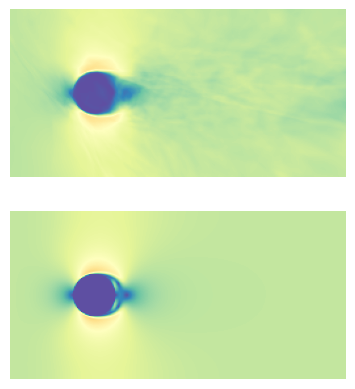

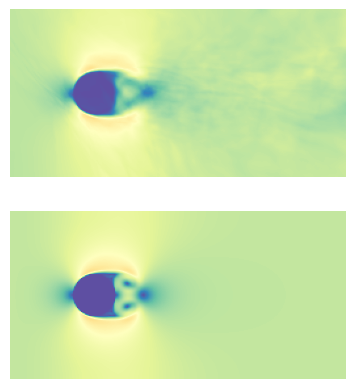

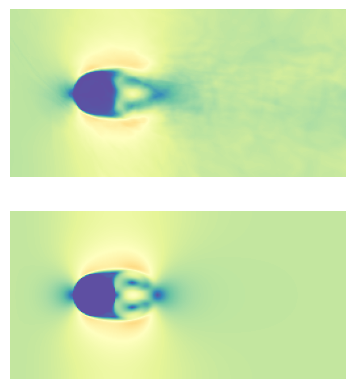

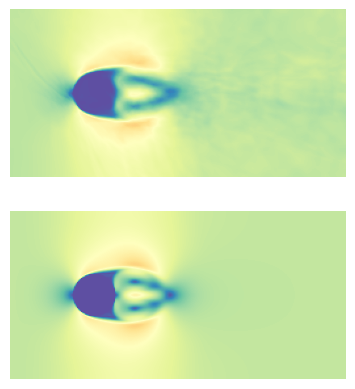

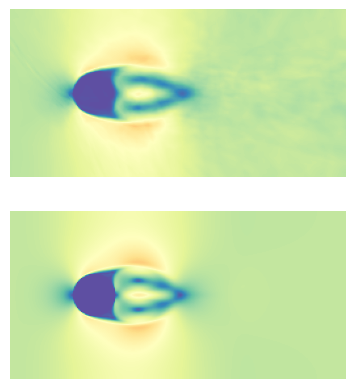

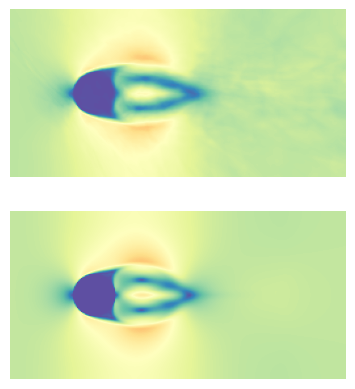

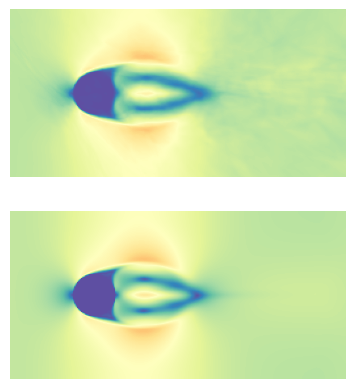

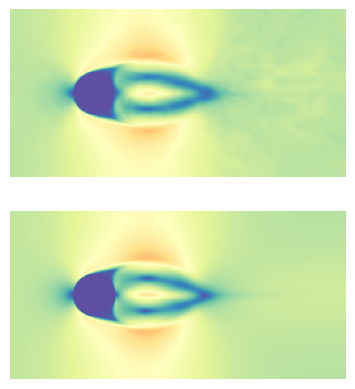

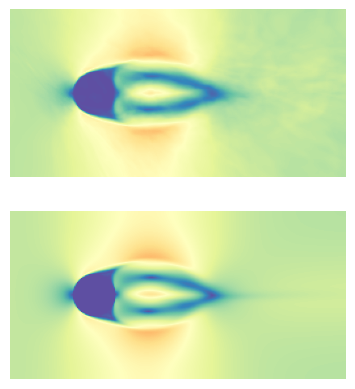

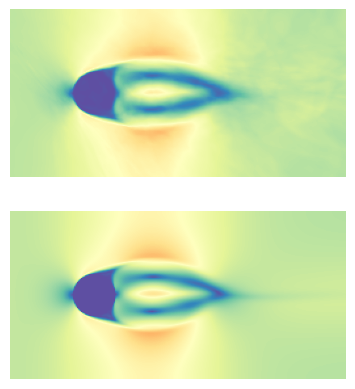

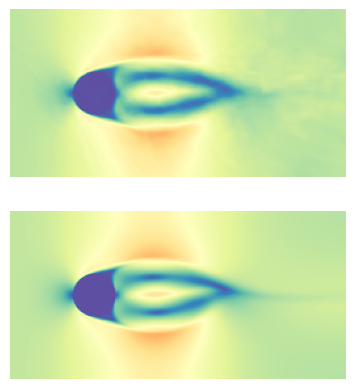

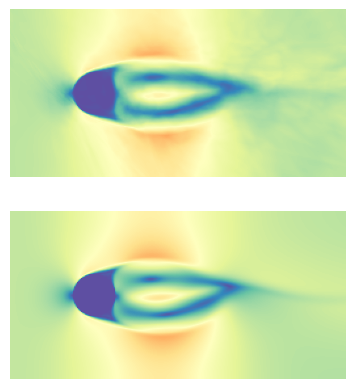

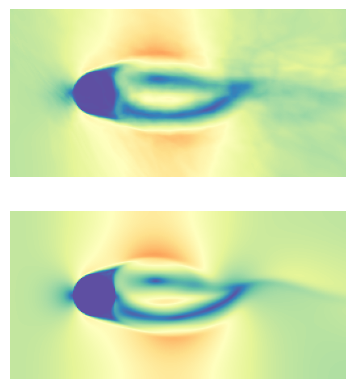

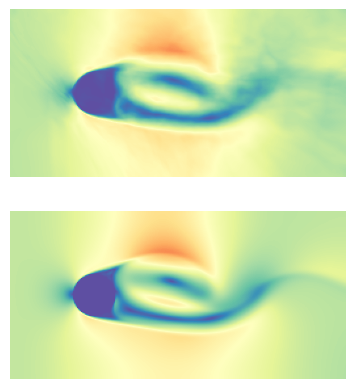

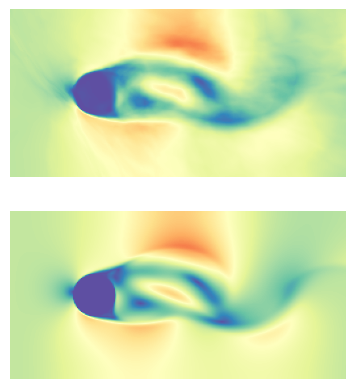

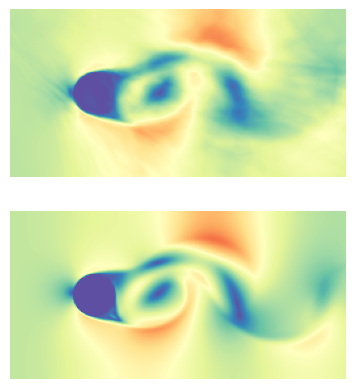

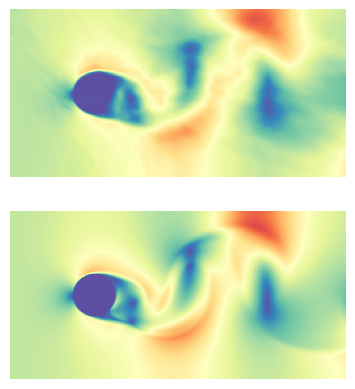

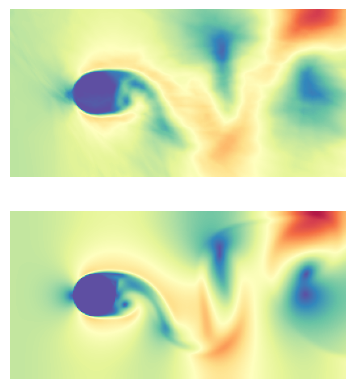

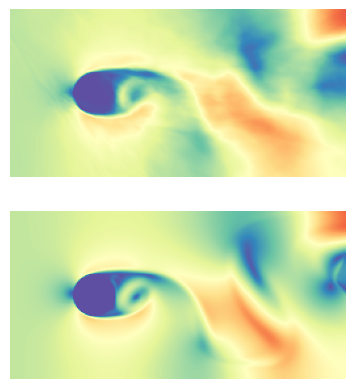

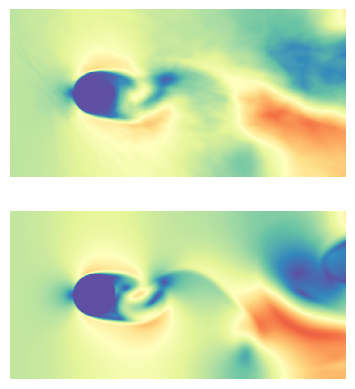

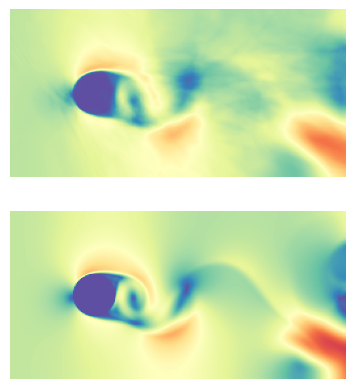

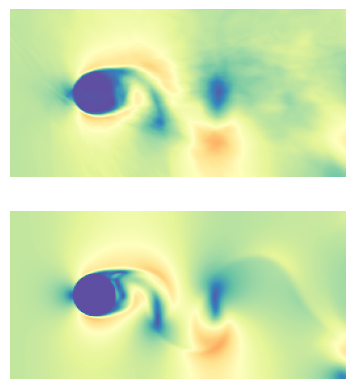

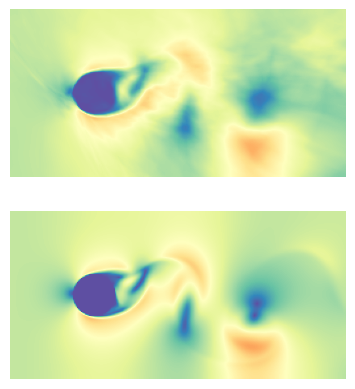

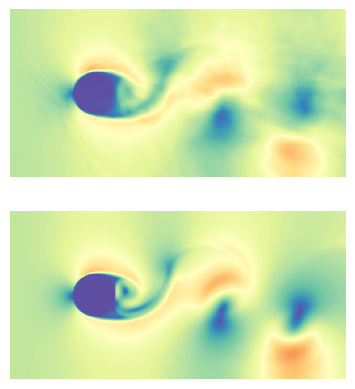

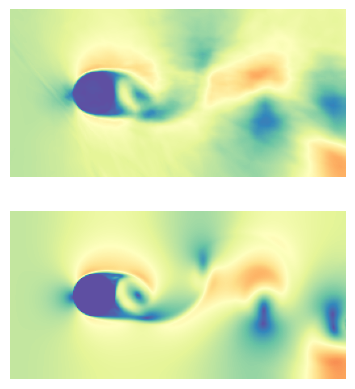

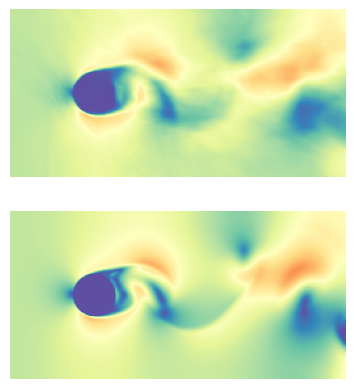

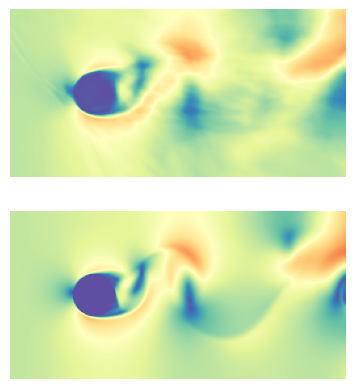

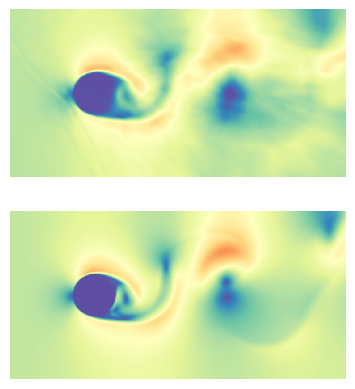

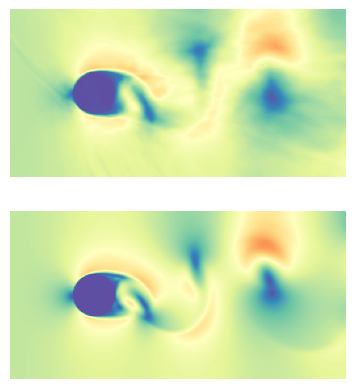

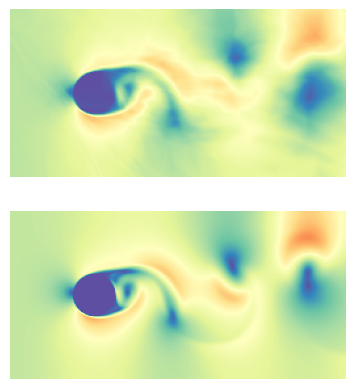

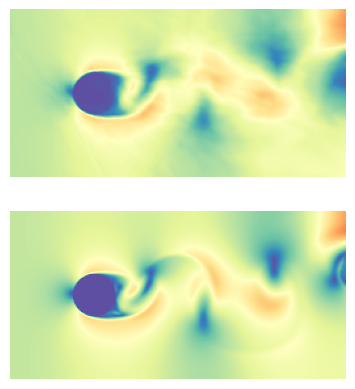

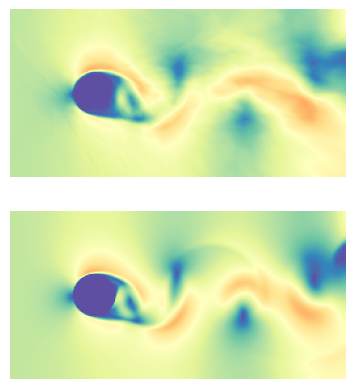

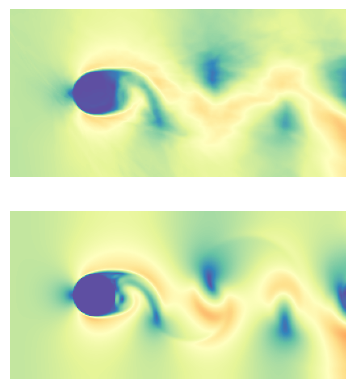

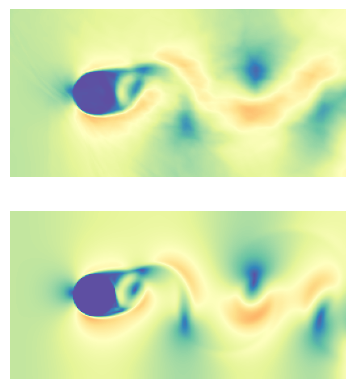

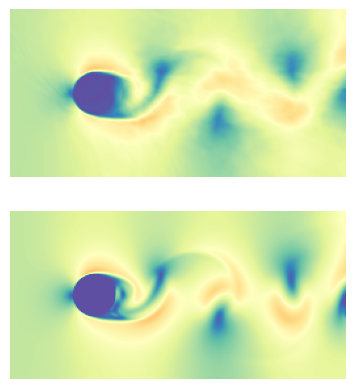

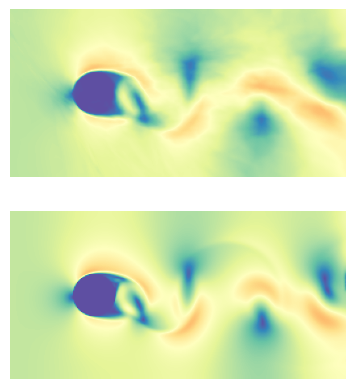

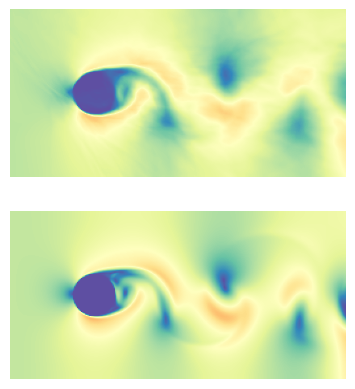

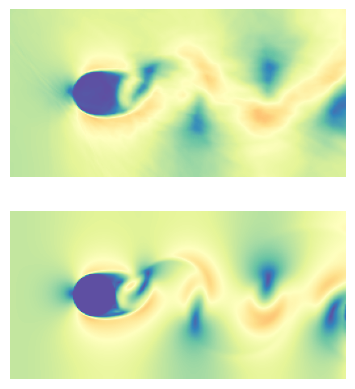

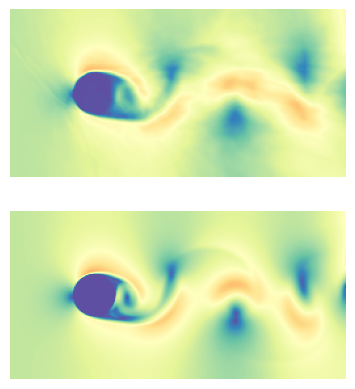

In [10]:
import matplotlib.pyplot as plt
for i in range(39):
    _, ax = plt.subplots(2,1)
    ax[0].imshow(reconstruction_inr[i,:,:], vmin= 0 ,vmax = 1, cmap = 'Spectral_r')
    ax[0].axis("off")
    ax[1].imshow(full_field_data_whole_test_norm[i,:,:,0], vmin= 0 ,vmax = 1,cmap = 'Spectral_r')
    ax[1].axis("off")
    plt.show()